In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
import tensorflow as tf
from functools import partial
from tensorflow import keras
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

import sklearn.decomposition
import sklearn.cross_decomposition
import sklearn.manifold
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import pydot

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
def load_data():
    markets = []
    path = ["Processed_DJI.csv","Processed_NASDAQ.csv","Processed_NYSE.csv","Processed_RUSSELL.csv","Processed_S&P.csv"]
    for i in range(5):
        csv_path = os.path.join("CNNpred/", path[i])
        markets.append(pd.read_csv(csv_path))
    return markets


In [3]:
class add_missing_attributes():
    def __init__(self):
        self = self
    def fit(self, markets):
        return self
    def transform(self,markets):
        a = markets[0].columns 
        b = markets[1].columns
        c = markets[2].columns
        d = markets[3].columns
        e = markets[4].columns
        unique_attributes = list(set().union(a,b,c,d,e))
        new_markets = []
        for index,m in enumerate(markets):
            dataset_missing_attributes = set(unique_attributes) - set(m.columns)
            dataset_complete = m.copy()
            # print(dataset_missing_attributes)
            for i in dataset_missing_attributes:
                if(index != 0):
                    dataset_complete[i] = new_markets[0][i]
                else:
                    dataset_complete[i] = markets[2][i]

            new_markets.append(dataset_complete)
        return new_markets

In [4]:
class encode():
    def __init__(self):
        self = self
    def fit(self):
        return self      
    def transform(self, markets):
        new_markets = markets
        encoder = LabelEncoder()
        encoder_name = LabelEncoder()
        prune_attr = ['EMA_20','EMA_50','EMA_200','ROC_5','ROC_10','ROC_15','mom2','mom3']
        attr_fill_mean = ['EMA_10']
        attributes_fillna_bfill = ['mom','mom1','ROC_20']
        other_attr = ['Oil',
         'Gold',
         'GBP',
         'JPY',
         'CAD',
         'CNY',
         'AAPL',
         'AMZN',
         'GE',
         'JNJ',
         'JPM',
         'MSFT',
         'WFC',
         'XOM',
         'FCHI',
         'FTSE',
         'GDAXI',
         'DJI',
         'HSI',
         'IXIC',
         'SSEC',
         'S&P',
         'RUT',
         'CTB3M',
         'CTB6M',
         'CTB1Y',
         'CAC-F',
         'DAX-F',
         'FTSE-F',
         'HSI-F',
         'KOSPI-F',
         'wheat-F',
         'GSPC',
         'NYSE']
        
        for i in range(5):
            new_markets[i]["Date"] = encoder.fit_transform(markets[i]["Date"])
            new_markets[i]["Date"] = encoder.fit_transform(markets[i]["Date"])
            
            new_markets[i]["Volume"] = markets[i]['Volume'].fillna(0)
            for v in prune_attr:
                new_markets[i].drop([v],axis= 1, inplace=True)
            for v in attr_fill_mean:
                new_markets[i][v] = markets[i][v].fillna(markets[i][v].mean())
            for v in attributes_fillna_bfill:
                new_markets[i][v] = markets[i][v].fillna(markets[i][v].mean())
            for v in other_attr:
                new_markets[i][v] = markets[i][v].interpolate()
            
            new_markets[i] = new_markets[i].dropna()
        
        r = pd.concat([new_markets[0],new_markets[1],new_markets[2],new_markets[3],new_markets[4]], axis=0)
#         r["Name"] = encoder_name.fit_transform(r["Name"])
        r = r.reset_index()
        return r

In [5]:
class encodeName():
    def __init__(self):
        self = self
    def fit(self):
        return self
    def transform(self, data):
        name = pd.DataFrame()
        name['results'] = data['Name']

        encoder = LabelBinarizer()
        name_1hot = encoder.fit_transform(name['results'])
        
        m = []
        for j in range(5):
            m.append('Name-%d' % (j))
        for i,elem in enumerate(m):
            name[elem] = name_1hot[:,i]
        name = name.drop(['results'], axis=1)
        result = pd.concat([data,name], axis = 1)
        return result

In [7]:
class scaler():
    def __init__(self):
        self = self
    def fit(self):
        return self
    def transform(self, data):
        
        scaled_features = data.copy()
        attributes = list(data.columns)
        attributes.remove("Date")
        attributes.remove("Name")
#         attributes.remove("Close")
        attributes.remove("index")
        features = scaled_features[attributes]
        scaler = StandardScaler().fit(features.values)
        features = scaler.transform(features.values)
        new_data = pd.DataFrame(data = features, columns=attributes)
        
        new_data["Date"] = data["Date"]
        new_data["Name"] = data["Name"]
#         new_data["Close"] = data["Close"]

        return new_data.dropna()

In [8]:
data_prep_pipeline = Pipeline([
        ('add_missing_attributes', add_missing_attributes()),
        ('encode', encode()),
#         ('fill_missing_val', fill_missing_val()),
        ('scaler', scaler()),
        ('encodeName', encodeName()),
    ])

markets = load_data()
m_pd = data_prep_pipeline.transform(markets)

In [9]:
lag = 60
m_labels_pd = m_pd.loc[
    ((m_pd['Date'] > (lag)) &
    (m_pd['Date'] < (m_pd['Date'].max())))
]

In [10]:
train_label, test_label_temp = train_test_split(m_labels_pd, test_size=0.3, random_state=10, stratify = m_labels_pd['Name'])
val_label, test_label = train_test_split(test_label_temp, test_size=0.5, random_state=10, stratify= test_label_temp['Name'])

In [11]:
def prepareSupervisedData(index, days, data, targetm):
    new_data = np.empty((index.shape[0], days , data.shape[1]))
    label = np.empty((index.shape[0]))
    
    for i,(_, row) in enumerate(index.iterrows()):
        date = row['Date']
#         name = row['Name']
        name0 = row['Name-0']
        name1 = row['Name-1']
        name2 = row['Name-2']
        name3 = row['Name-3']
        name4 = row['Name-4']
        
        
        row_input = data.loc[
            (data['Date'] <= date) & 
            (data['Date'] > date - days) &
            (data['Name-0'] == name0) &
            (data['Name-1'] == name1) &
            (data['Name-2'] == name2) &
            (data['Name-3'] == name3) &
            (data['Name-4'] == name4)
        ]
        new_data[i] = row_input
        
        targetm_char = 'Name-'+str(targetm)
        close = data.loc[((data['Date'] == date) & (data[targetm_char] == 1)), 'Close'].item()
        next_close = data.loc[((data['Date'] == date + 1) & (data[targetm_char] == 1)), 'Close'].item()
        label[i] = np.sign(next_close - close)
        if (next_close - close) < 0:
            label[i] = 0
        elif (next_close - close) > 0:
            label[i] = 1
        elif (next_close == close):
            label[i] = 0

    return new_data[:,:,:,np.newaxis], label

lag = 60
m_pd.drop(['Name'],axis=1,inplace=True)
x_train, y_train = prepareSupervisedData(train_label, lag, m_pd, 4)
x_val, y_val = prepareSupervisedData(val_label, lag, m_pd, 4)
x_test, y_test = prepareSupervisedData(test_label, lag, m_pd, 4)

## Model: 2D CNN + ANN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape


# checkpoint_path = "/content/gdrive/MyDrive/Trained_Model/training_1/cp.ckpt"
checkpoint_path = "Trained_Model/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model = keras.models.Sequential([
    Conv2D(filters = 40, kernel_size = (1,82), input_shape=(60, 82, 1)),
    Reshape((60,40,1)),
    Dropout(0.2),
    Conv2D(filters = 8, kernel_size = (1,40), input_shape=(60, 82, 1)),
    Reshape((60,8,1)),
    Conv2D(filters = 1, kernel_size = (3,1)),
    MaxPooling2D(pool_size=(2,1)),
    Conv2D(filters = 1, kernel_size = (3,1)),
    MaxPooling2D(pool_size=(2,1)),
    Flatten(),
    Dense(units=104, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid'),
])

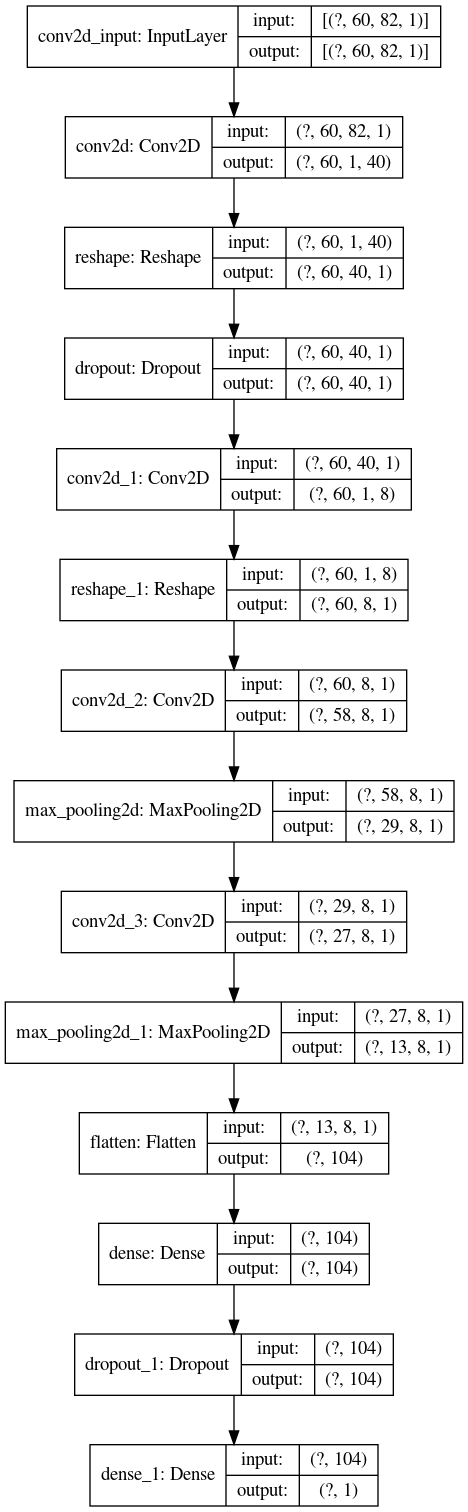

In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 1, 40)         3320      
_________________________________________________________________
reshape (Reshape)            (None, 60, 40, 1)         0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 1, 8)          328       
_________________________________________________________________
reshape_1 (Reshape)          (None, 60, 8, 1)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 8, 1)          4         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 8, 1)          0

In [15]:
model.compile(
    loss="binary_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"])

history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=64, 
                    validation_data = (x_val, y_val),
                    callbacks = [cp_callback])

Epoch 1/100
103/106 [============================>.] - ETA: 0s - loss: 0.8150 - accuracy: 0.5121
Epoch 00001: saving model to Trained_Model/training_1/cp.ckpt
106/106 [==============================] - 1s 11ms/step - loss: 0.8126 - accuracy: 0.5130 - val_loss: 0.6896 - val_accuracy: 0.5461
Epoch 2/100
105/106 [============================>.] - ETA: 0s - loss: 0.6990 - accuracy: 0.5171
Epoch 00002: saving model to Trained_Model/training_1/cp.ckpt
106/106 [==============================] - 1s 9ms/step - loss: 0.6990 - accuracy: 0.5173 - val_loss: 0.6953 - val_accuracy: 0.4920
Epoch 3/100
101/106 [===========================>..] - ETA: 0s - loss: 0.6952 - accuracy: 0.5350
Epoch 00003: saving model to Trained_Model/training_1/cp.ckpt
106/106 [==============================] - 1s 10ms/step - loss: 0.6951 - accuracy: 0.5346 - val_loss: 0.6926 - val_accuracy: 0.5170
Epoch 4/100
102/106 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5283
Epoch 00004: saving model to Tr

101/106 [===========================>..] - ETA: 0s - loss: 0.1895 - accuracy: 0.9138
Epoch 00057: saving model to Trained_Model/training_1/cp.ckpt
106/106 [==============================] - 1s 10ms/step - loss: 0.1890 - accuracy: 0.9144 - val_loss: 0.1315 - val_accuracy: 0.9459
Epoch 58/100
104/106 [============================>.] - ETA: 0s - loss: 0.1868 - accuracy: 0.9214
Epoch 00058: saving model to Trained_Model/training_1/cp.ckpt
106/106 [==============================] - 1s 10ms/step - loss: 0.1861 - accuracy: 0.9217 - val_loss: 0.1203 - val_accuracy: 0.9563
Epoch 59/100
105/106 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9152
Epoch 00059: saving model to Trained_Model/training_1/cp.ckpt
106/106 [==============================] - 1s 9ms/step - loss: 0.1981 - accuracy: 0.9151 - val_loss: 0.1235 - val_accuracy: 0.9486
Epoch 60/100
105/106 [============================>.] - ETA: 0s - loss: 0.1836 - accuracy: 0.9240
Epoch 00060: saving model to Trained_Mod

In [16]:
score, acc = model.evaluate(x_test, y_test)
print("Accuracy: ",acc)
y_pred = np.round(model(x_test))
print("F1: ", sklearn.metrics.f1_score(y_pred, y_test))

46/46 [==============================] - 0s 3ms/step - loss: 0.0383 - accuracy: 0.9840
Accuracy:  0.984049916267395
F1:  0.9854153455928979


#### Simple ANN

In [21]:
np.random.seed(42)
tf.random.set_seed(42)
model2 = keras.models.Sequential([
    Dense(units=1, activation='relu', input_shape=(4920,1)),
    Reshape((1, 4920)),
    Dense(units=104, activation='relu',),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid'),
])

In [22]:
x_train_n = x_train.reshape((x_train.shape[0], -1))
x_val_n = x_val.reshape((x_val.shape[0], -1))
x_test_n = x_test.reshape((x_test.shape[0], -1))

x_train_ann = x_train_n.reshape((x_train_n.shape[0],x_train_n.shape[1],1))
x_val_ann = x_val_n.reshape((x_val_n.shape[0],x_val_n.shape[1],1))
x_test_ann = x_test_n.reshape((x_test_n.shape[0],x_test_n.shape[1],1))

model2.compile(
                loss="binary_crossentropy", 
                optimizer="adam",
                metrics=["accuracy"])

history = model2.fit(x_train_ann, 
                    y_train, 
                    epochs=5, 
                    batch_size=128, 
                    validation_data = (x_val_ann, y_val))


Epoch 1/5
53/53 [==============================] - 1s 18ms/step - loss: 6.9941 - accuracy: 0.5404 - val_loss: 6.7939 - val_accuracy: 0.5545
Epoch 2/5
53/53 [==============================] - 1s 15ms/step - loss: 6.9978 - accuracy: 0.5411 - val_loss: 6.7939 - val_accuracy: 0.5545
Epoch 3/5
53/53 [==============================] - 1s 15ms/step - loss: 6.9978 - accuracy: 0.5411 - val_loss: 6.7939 - val_accuracy: 0.5545
Epoch 4/5
53/53 [==============================] - 1s 15ms/step - loss: 6.9978 - accuracy: 0.5411 - val_loss: 6.7939 - val_accuracy: 0.5545
Epoch 5/5
53/53 [==============================] - 1s 15ms/step - loss: 6.9978 - accuracy: 0.5411 - val_loss: 6.7939 - val_accuracy: 0.5545


In [23]:
def simple_ann(xtrain,xval,xtest,ytrain = y_train,yval = y_val,ytest = y_test, model=model2):
    print("simple ANN")
#     score = model.evaluate(xval, yval)
#     print("Accuracy: ",score)
#     y_pred = np.round(model(x_val))
#     print("F1: ", sklearn.metrics.f1_score(y_pred, yval))
    score, acc = model.evaluate(xtest, ytest)
    print("Accuracy: ",acc)
    y_pred = np.round(model(xtest)).reshape(-1)
    print("F1: ", sklearn.metrics.f1_score(y_pred, ytest))

In [24]:
simple_ann(x_train_ann, x_val_ann, x_test_ann)

simple ANN
46/46 [==============================] - 0s 2ms/step - loss: 6.9372 - accuracy: 0.5451
Accuracy:  0.545076310634613
F1:  0.7055655296229802


## Model: 2D CNN + Linear Models

In [25]:
cnn = keras.models.Sequential(model.layers[:10])

In [26]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 1, 40)         3320      
_________________________________________________________________
reshape (Reshape)            (None, 60, 40, 1)         0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 1, 8)          328       
_________________________________________________________________
reshape_1 (Reshape)          (None, 60, 8, 1)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 8, 1)          4         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 8, 1)         

In [27]:
def linear_model_gbn(xtrain,xval,xtest,ytrain = y_train,yval = y_val,ytest = y_test):
    print("\n Gaussian Naive Bayes")
    reg = GaussianNB()
    reg.fit(xtrain, ytrain)
#     print("Accuracy: ", reg.score(xval, yval))
#     y_pred = reg.predict(xval)
#     print("F1 ", sklearn.metrics.f1_score(y_pred, yval))
    print("Accuracy: ", reg.score(xtest, ytest))
    y_pred = reg.predict(xtest)
    print("F1: ", sklearn.metrics.f1_score(y_pred, ytest))
    
linear_model_gbn(cnn(x_train),cnn(x_val),cnn(x_test))


 Gaussian Naive Bayes
Accuracy:  0.5707350901525658
F1:  0.631328171530673


In [28]:
def linear_model_log(xtrain,xval,xtest,ytrain = y_train,yval = y_val,ytest = y_test):
    print("\n Logistic Regression")
    reg = LogisticRegression(max_iter=300, random_state=42)
    reg.fit(xtrain, ytrain)
#     print("Accuracy: ", reg.score(xval, yval))
#     y_pred = reg.predict(xval)
#     print("F1 ", sklearn.metrics.f1_score(y_pred, yval))
    print("Accuracy: ", reg.score(xtest, ytest))
    y_pred = reg.predict(xtest)
    print("F1: ", sklearn.metrics.f1_score(y_pred, ytest))

linear_model_log(cnn(x_train),cnn(x_val),cnn(x_test))


 Logistic Regression
Accuracy:  0.5742024965325936
F1:  0.6405152224824355


/home/elim/anaconda3/envs/ds/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [29]:
def linear_model_sdg(xtrain,xval,xtest,ytrain = y_train,yval = y_val,ytest = y_test):
    print("\n SGD Classifier")
    reg = SGDClassifier(max_iter=4, tol=None, random_state=42,
                   loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
    reg.fit(xtrain, ytrain)
#     print("Accuracy: ", reg.score(xval, yval))
#     y_pred = reg.predict(xval)
#     print("F1 ", sklearn.metrics.f1_score(y_pred, yval))
    print("Accuracy: ", reg.score(xtest, ytest))
    y_pred = reg.predict(xtest)
    print("F1: ", sklearn.metrics.f1_score(y_pred, ytest))


linear_model_sdg(cnn(x_train),cnn(x_val),cnn(x_test))


 SGD Classifier
Accuracy:  0.48751733703190014
F1:  0.3138347260909935


## Model: 2D CNN + Ensemble

In [30]:
def en_model_rfc(xtrain,xval,xtest,ytrain = y_train,yval = y_val,ytest = y_test):
    print("\n Random Forest")
    reg = RandomForestClassifier(n_estimators=200, max_leaf_nodes=24, 
                                 n_jobs=-1, random_state=42)
    reg.fit(xtrain, ytrain)
#     print("Accuracy: ", reg.score(xval, yval))
#     y_pred = reg.predict(xval)
#     print("F1 ", sklearn.metrics.f1_score(y_pred, yval))
    print("Accuracy: ", reg.score(xtest, ytest))
    y_pred = reg.predict(xtest)
    print("F1: ", sklearn.metrics.f1_score(y_pred, ytest))
    
en_model_rfc(cnn(x_train),cnn(x_val),cnn(x_test))


 Random Forest
Accuracy:  0.7635228848821082
F1:  0.8181333333333334


In [31]:
def en_model_ada(xtrain,xval,xtest,ytrain = y_train,yval = y_val,ytest = y_test):
    print("\n Ada Boost")
    reg = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=3), n_estimators=100,
            algorithm="SAMME.R", learning_rate=0.5, random_state=42)
    
    reg.fit(xtrain, ytrain)
#     print("Accuracy: ", reg.score(xval, yval))
#     y_pred = reg.predict(xval)
#     print("F1 ", sklearn.metrics.f1_score(y_pred, yval))
    print("Accuracy: ", reg.score(xtest, ytest))
    y_pred = reg.predict(xtest)
    print("F1: ", sklearn.metrics.f1_score(y_pred, ytest))
    
en_model_ada(cnn(x_train),cnn(x_val),cnn(x_test))


 Ada Boost
Accuracy:  0.955617198335645
F1:  0.9596977329974811


## Model: PCA + Linear Models

In [48]:
x_train_n = x_train.reshape((x_train.shape[0], -1))
x_val_n = x_val.reshape((x_val.shape[0], -1))
x_test_n = x_test.reshape((x_test.shape[0], -1))
features = 104

x_train_pca = StandardScaler().fit_transform(x_train_n)
x_val_pca = StandardScaler().fit_transform(x_val_n)
x_test_pca = StandardScaler().fit_transform(x_test_n)

In [49]:
pca = sklearn.decomposition.PCA()
pca.fit(x_train_pca)

pca_result1 = pca.transform(x_train_pca)
pca_result2 = pca.transform(x_val_pca)
pca_result3 = pca.transform(x_test_pca)

In [53]:
linear_model_gbn(pca_result1[:,0:features],pca_result2[:,0:features],pca_result3[:,0:features])
print()
linear_model_log(pca_result1[:,0:features],pca_result2[:,0:features],pca_result3[:,0:features])
print()
linear_model_sdg(pca_result1[:,0:features],pca_result2[:,0:features],pca_result3[:,0:features])


 Gaussian Naive Bayes
Accuracy:  0.5804438280166435
F1:  0.6068875893437297


 Logistic Regression
Accuracy:  0.6074895977808599
F1:  0.677309007981756


 SGD Classifier
Accuracy:  0.5305131761442441
F1:  0.5728706624605678


In [54]:
en_model_rfc(pca_result1[:,0:features],pca_result2[:,0:features],pca_result3[:,0:features])


 Random Forest
Accuracy:  0.7337031900138696
F1:  0.8028747433264887


In [55]:
en_model_ada(pca_result1[:,0:features],pca_result2[:,0:features],pca_result3[:,0:features])


 Ada Boost
Accuracy:  0.9563106796116505
F1:  0.9602021478205938


In [56]:
model3 = keras.models.Sequential([
    Dense(units=1, activation='relu', input_shape=(104,1)),
    Reshape((1, 104)),
    Dense(units=104, activation='relu',),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid'),
])

In [57]:
xtr= pca_result1[:,0:features].reshape((pca_result1[:,0:features].shape[0],pca_result1[:,0:features].shape[1],1))
xv=pca_result2[:,0:features].reshape((pca_result2[:,0:features].shape[0],pca_result2[:,0:features].shape[1],1))
xte=pca_result3[:,0:features].reshape((pca_result3[:,0:features].shape[0],pca_result3[:,0:features].shape[1],1))

model3.compile(
                loss="binary_crossentropy", 
                optimizer="adam",
                metrics=["accuracy"])

history = model3.fit(xtr, 
                    y_train, 
                    epochs=5, 
                    batch_size=128, 
                    validation_data = (xv, y_val))

Epoch 1/5
53/53 [==============================] - 0s 4ms/step - loss: 0.7182 - accuracy: 0.5307 - val_loss: 0.6782 - val_accuracy: 0.5559
Epoch 2/5
53/53 [==============================] - 0s 2ms/step - loss: 0.6748 - accuracy: 0.5827 - val_loss: 0.6589 - val_accuracy: 0.6037
Epoch 3/5
53/53 [==============================] - 0s 2ms/step - loss: 0.6563 - accuracy: 0.6081 - val_loss: 0.6449 - val_accuracy: 0.6204
Epoch 4/5
53/53 [==============================] - 0s 2ms/step - loss: 0.6356 - accuracy: 0.6349 - val_loss: 0.6273 - val_accuracy: 0.6495
Epoch 5/5
53/53 [==============================] - 0s 3ms/step - loss: 0.6073 - accuracy: 0.6652 - val_loss: 0.6079 - val_accuracy: 0.6738


In [58]:
print()
simple_ann(xtr,xv,xte, model=model3)


simple ANN
46/46 [==============================] - 0s 705us/step - loss: 0.6167 - accuracy: 0.6782
Accuracy:  0.6782246828079224
F1:  0.71


## Model: tSNE + Linear Models

In [59]:
pca_h = sklearn.decomposition.PCA()
pca_h.fit(x_train_pca)

tsne = sklearn.manifold.TSNE(n_components=2, verbose=1)
p = pca_h.transform(x_train_pca)
tsne_result1 = tsne.fit_transform(p[:,:50])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6727 samples in 0.030s...
[t-SNE] Computed neighbors for 6727 samples in 2.994s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6727
[t-SNE] Computed conditional probabilities for sample 2000 / 6727
[t-SNE] Computed conditional probabilities for sample 3000 / 6727
[t-SNE] Computed conditional probabilities for sample 4000 / 6727
[t-SNE] Computed conditional probabilities for sample 5000 / 6727
[t-SNE] Computed conditional probabilities for sample 6000 / 6727
[t-SNE] Computed conditional probabilities for sample 6727 / 6727
[t-SNE] Mean sigma: 9.412183
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.774216
[t-SNE] KL divergence after 1000 iterations: 1.713599


In [68]:
a = pca_h.transform(x_val_pca)
tsne_result2 = tsne.fit_transform(a[:,:50])

b = pca_h.transform(x_test_pca)
tsne_result3 = tsne.fit_transform(b[:,:50])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1441 samples in 0.004s...
[t-SNE] Computed neighbors for 1441 samples in 0.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1441
[t-SNE] Computed conditional probabilities for sample 1441 / 1441
[t-SNE] Mean sigma: 12.532647
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.809723
[t-SNE] KL divergence after 1000 iterations: 1.006127
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1442 samples in 0.007s...
[t-SNE] Computed neighbors for 1442 samples in 0.242s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1442
[t-SNE] Computed conditional probabilities for sample 1442 / 1442
[t-SNE] Mean sigma: 12.833691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.933464
[t-SNE] KL divergence after 1000 iterations: 1.019098


In [69]:
linear_model_gbn(tsne_result1,tsne_result2,tsne_result3)
print()
linear_model_log(tsne_result1,tsne_result2,tsne_result3)
print()
linear_model_sdg(tsne_result1,tsne_result2,tsne_result3)


 Gaussian Naive Bayes
Accuracy:  0.5450762829403606
F1:  0.7055655296229802


 Logistic Regression
Accuracy:  0.5450762829403606
F1:  0.7055655296229802


 SGD Classifier
Accuracy:  0.49167822468793343
F1:  0.5351934051997463


In [70]:
en_model_rfc(tsne_result1,tsne_result2,tsne_result3)


 Random Forest
Accuracy:  0.5249653259361997
F1:  0.6806526806526807


In [71]:
en_model_ada(tsne_result1,tsne_result2,tsne_result3)


 Ada Boost
Accuracy:  0.5256588072122053
F1:  0.5933412604042807


In [72]:
model4 = keras.models.Sequential([
    Dense(units=1, activation='relu', input_shape=(2,1)),
    Reshape((1, 2)),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid'),
])

In [73]:
xtr= tsne_result1.reshape((tsne_result1.shape[0],tsne_result1.shape[1], 1))
xv= tsne_result2.reshape((tsne_result2.shape[0],tsne_result2.shape[1], 1))
xte= tsne_result3.reshape((tsne_result3.shape[0],tsne_result3.shape[1], 1))

model4.compile(
                loss="binary_crossentropy", 
                optimizer="adam",
                metrics=["accuracy"])

history = model4.fit(xtr, 
                    y_train, 
                    epochs=5, 
                    batch_size=128, 
                    validation_data = (xv, y_val))

Epoch 1/5
53/53 [==============================] - 0s 3ms/step - loss: 4.0073 - accuracy: 0.4907 - val_loss: 3.5046 - val_accuracy: 0.4754
Epoch 2/5
53/53 [==============================] - 0s 1ms/step - loss: 3.8567 - accuracy: 0.4833 - val_loss: 3.2986 - val_accuracy: 0.4774
Epoch 3/5
53/53 [==============================] - 0s 1ms/step - loss: 3.5957 - accuracy: 0.4885 - val_loss: 3.1407 - val_accuracy: 0.4698
Epoch 4/5
53/53 [==============================] - 0s 4ms/step - loss: 3.4385 - accuracy: 0.4871 - val_loss: 3.0147 - val_accuracy: 0.4684
Epoch 5/5
53/53 [==============================] - 0s 2ms/step - loss: 3.3893 - accuracy: 0.4813 - val_loss: 2.8212 - val_accuracy: 0.4705


In [74]:
simple_ann(xtr,xv,xte, model=model4)

simple ANN
46/46 [==============================] - 0s 625us/step - loss: 2.9197 - accuracy: 0.4695
Accuracy:  0.4694868326187134
F1:  0.3224092116917626


## Model: No Dimension Reduction + Linear Models

In [75]:
x_train_n = x_train.reshape((x_train.shape[0], -1))
x_val_n = x_val.reshape((x_val.shape[0], -1))
x_test_n = x_test.reshape((x_test.shape[0], -1))

In [76]:
linear_model_gbn(x_train_n,x_val_n,x_test_n)
linear_model_log(x_train_n,x_val_n,x_test_n)
linear_model_sdg(x_train_n,x_val_n,x_test_n)


 Gaussian Naive Bayes
Accuracy:  0.6393897364771152
F1:  0.6353436185133239

 Logistic Regression


/home/elim/anaconda3/envs/ds/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.8793342579750347
F1:  0.8900126422250316

 SGD Classifier
Accuracy:  0.4549237170596394
F1:  0.0


## Model: No Dimension Reduction + Ensemble

In [77]:
en_model_rfc(x_train_n,x_val_n,x_test_n)


 Random Forest
Accuracy:  0.8918169209431346
F1:  0.9097222222222222


In [78]:
en_model_ada(x_train_n,x_val_n,x_test_n)


 Ada Boost
Accuracy:  0.9965325936199723
F1:  0.9968294229549778


## Visualisations

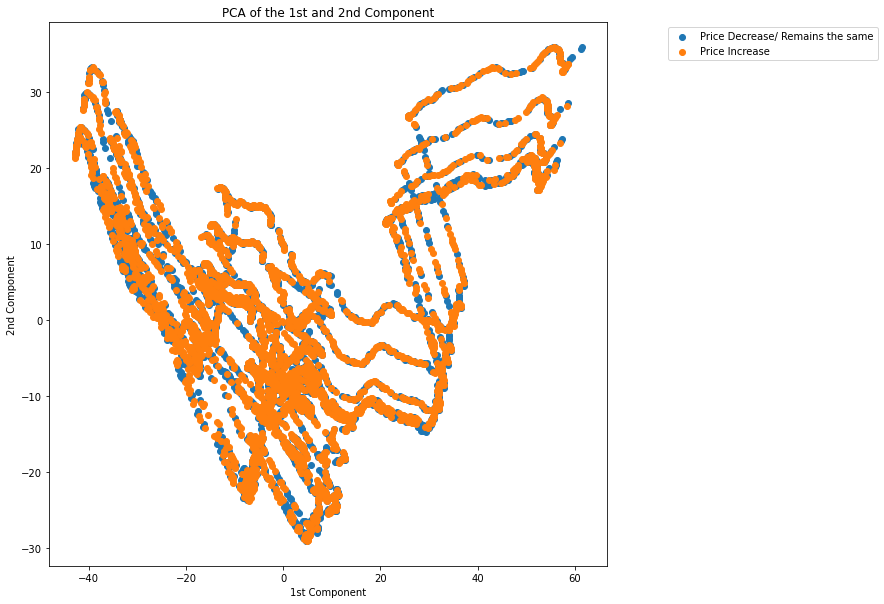

In [96]:
pca1,pca2 = pca_result1[:,0], pca_result1[:,1]

fig,ax = plt.subplots(figsize=(10,10))
for lvl in range(2):
    ln = ["Price Decrease/ Remains the same", "Price Increase"]
    i = (y_train == lvl)
    ax.scatter(pca1[i], pca2[i], label=ln[lvl])

ax.set_title("PCA of the 1st and 2nd Component")
ax.set_xlabel("1st Component")
ax.set_ylabel("2nd Component")
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

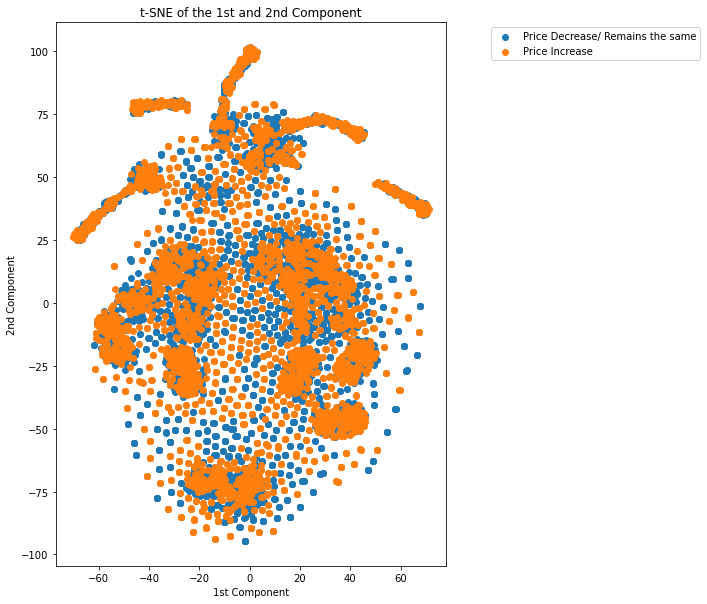

In [97]:
pca1,pca2 = tsne_result1[:,0], tsne_result1[:,1]

fig,ax = plt.subplots(figsize=(10,10))
for lvl in range(2):
    ln = ["Price Decrease/ Remains the same", "Price Increase"]
    i = (y_train == lvl)
    ax.scatter(pca1[i], pca2[i], label=ln[lvl])

ax.set_aspect('equal')
ax.set_title("t-SNE of the 1st and 2nd Component")
ax.set_xlabel("1st Component")
ax.set_ylabel("2nd Component")
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

## Correlations

In [42]:
markets[4].corr()

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
Close,1.000000,-0.026512,0.014905,0.014140,0.014884,0.013074,0.036268,0.052317,0.061095,0.064272,...,-0.017463,-0.007010,0.010069,0.014651,0.010654,-0.000803,-0.000693,-0.012812,-0.019746,-0.021366
Volume,-0.026512,1.000000,-0.076513,-0.004393,0.014723,-0.003473,-0.048215,-0.019406,-0.041006,-0.025288,...,0.006742,0.027267,-0.061320,-0.045736,-0.005965,0.001085,0.003683,0.019767,0.028697,0.036394
mom,0.014905,-0.076513,1.000000,-0.051408,0.023095,-0.064585,0.422857,0.279707,0.239659,0.195592,...,0.465489,0.173100,0.886430,0.975561,-0.028157,-0.231155,-0.232157,0.139613,0.203788,0.007269
mom1,0.014140,-0.004393,-0.051408,1.000000,-0.051511,0.023115,0.403718,0.273996,0.237265,0.192534,...,-0.059843,0.073695,-0.044749,-0.044308,0.043212,0.032858,0.047704,-0.010123,0.045613,0.012436
mom2,0.014884,0.014723,0.023095,-0.051511,1.000000,-0.051504,0.445535,0.283877,0.242344,0.206585,...,0.008653,0.018308,0.008665,0.019147,0.007930,0.001906,-0.015363,-0.004272,0.011694,0.005715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dollar index-F,-0.000803,0.001085,-0.231155,0.032858,0.001906,0.029169,-0.086384,-0.064194,-0.048155,-0.042955,...,-0.543677,-0.334651,-0.198201,-0.226114,0.596993,1.000000,0.953878,-0.159015,-0.372699,-0.347124
Dollar index,-0.000693,0.003683,-0.232157,0.047704,-0.015363,0.034329,-0.082852,-0.065921,-0.048691,-0.044498,...,-0.528321,-0.325971,-0.199722,-0.226215,0.572503,0.953878,1.000000,-0.156925,-0.359829,-0.334305
wheat-F,-0.012812,0.019767,0.139613,-0.010123,-0.004272,-0.024196,0.058995,0.030399,0.014995,0.023546,...,0.155732,0.148058,0.135562,0.133290,-0.100279,-0.159015,-0.156925,1.000000,0.160597,0.109407
XAG,-0.019746,0.028697,0.203788,0.045613,0.011694,-0.021258,0.096985,0.042112,0.051754,0.049556,...,0.371554,0.867831,0.201130,0.194387,-0.264550,-0.372699,-0.359829,0.160597,1.000000,0.792705


In [ ]:
corr = markets[4].corr()
corr["Close"].sort_values(ascending=False)[:30]

In [ ]:
len(markets[4].columns)